In [3]:
# Packages
library(ggplot2)  # visualization
library(dplyr)    # data manipulation
library(tidyr)    # reshape and clean data
library(forcats)  # working with factors

In [4]:
# Read the dataset and load it to a data frame
file_path <- "/content/CreditCardFraud_Dataset-4.csv"
df <- read.csv(file_path)
# Data transformations
df$MerchantID <- as.factor(df$MerchantID)         # Ensures proper grouping in plots/summaries
df$TransactionType <- as.factor(df$TransactionType)  # So ggplot doesn't treat it as text
df$Class <- factor(df$Class, levels = c("Normal", "Fraudulent"))  # So "Fraudulent" is the positive class

In [5]:
# Transaction Type-Level Summary: Fraudulent vs Normal Transactions with Fraud Rate (%)
transaction_type_summary <- df %>%
  group_by(TransactionType, Class) %>%
  summarise(TransactionCount = n(), .groups = "drop") %>%
  pivot_wider(
    names_from = Class,
    values_from = TransactionCount,
    names_prefix = "Class_",
    values_fill = 0
  ) %>%
  mutate(
    Total = Class_Fraudulent + Class_Normal,
    FraudRate = round(100 * Class_Fraudulent / Total, 2)
  ) %>%
  arrange(desc(FraudRate))
print(transaction_type_summary)

# A tibble: 3 × 5
  TransactionType Class_Normal Class_Fraudulent Total FraudRate
  <fct>                  <int>            <int> <int>     <dbl>
1 Online                  3295              123  3418      3.6 
2 Mobile                  3283              110  3393      3.24
3 In-Store                3189                0  3189      0   


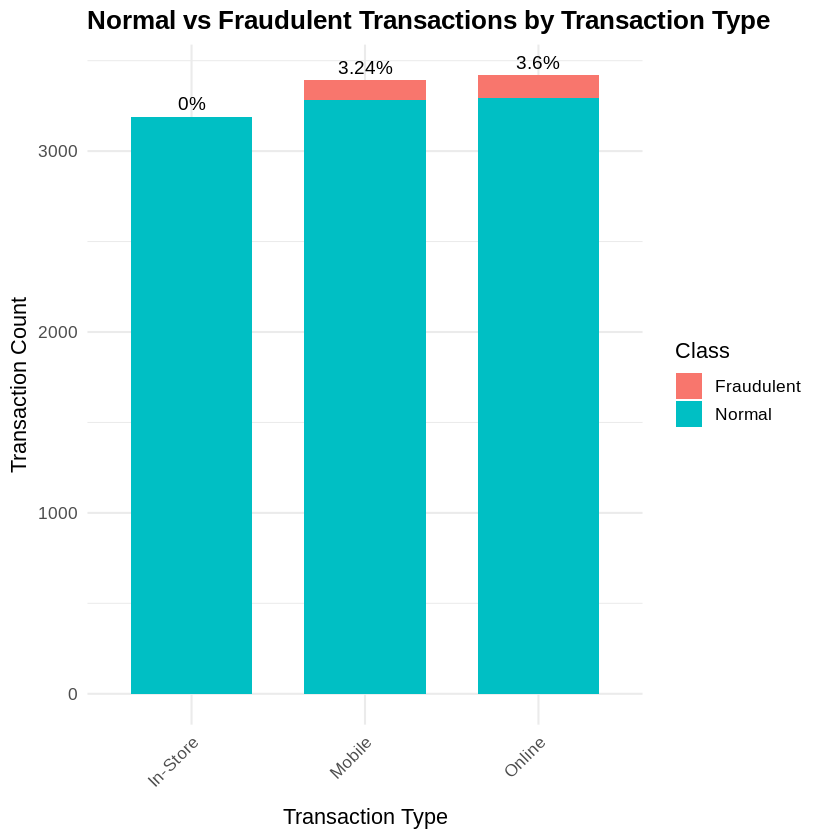

In [6]:
# Step 1: Create transaction_type_long for stacking
transaction_type_long <- transaction_type_summary %>%
  select(TransactionType, Class_Normal, Class_Fraudulent) %>%
  pivot_longer(
    cols = starts_with("Class_"),
    names_to = "Class",
    values_to = "Count"
  ) %>%
  mutate(Class = gsub("Class_", "", Class))
# Step 2: Plot stacked bars with fraud rate labels
ggplot(transaction_type_long, aes(x = TransactionType, y = Count, fill = Class)) +
  geom_col(width = 0.7) +
  geom_text(
    data = transaction_type_summary,
    aes(x = TransactionType, y = Total, label = paste0(FraudRate, "%")),
    vjust = -0.5,
    size = 4,
    inherit.aes = FALSE
  ) +
  labs(
    title = "Normal vs Fraudulent Transactions by Transaction Type",
    x = "Transaction Type",
    y = "Transaction Count",
    fill = "Class"
  ) +
  theme_minimal(base_size = 13) +
  theme(
    plot.title = element_text(face = "bold"),
    axis.text.x = element_text(angle = 45, hjust = 1)
  )

In [7]:
# Pearson's Chi-squared test
table_txn <- df %>%
  group_by(TransactionType, Class) %>%
  summarise(n = n(), .groups = "drop") %>%
  pivot_wider(names_from = Class, values_from = n, values_fill = 0)
chisq.test(as.matrix(table_txn[, -1]))


	Pearson's Chi-squared test

data:  as.matrix(table_txn[, -1])
X-squared = 112.65, df = 2, p-value < 2.2e-16


In [8]:
# The test yielded a Chi-squared statistic of 112.65 with 2 degrees of freedom, and a p-value less than 2.2e-16.
# This extremely small p-value provides strong statistical evidence against the null hypothesis of independence,
# indicating a significant relationship between transaction type and whether a transaction is classified as fraudulent.
# In other words, the likelihood of fraud varies meaningfully across transaction types.
# As such, TransactionType is not independent of fraud status and should be included as a categorical predictor in the logistic regression model.